Project Introduction: DiaryBot - Your AI-Powered Mood and Quote Companion

* Debajyoti Nag
* April 2025
* Jakarta, Indonesia

DiaryBot is a unique AI-driven project designed to enhance your personal journaling experience. At its core, DiaryBot is a conversational agent that interacts with you to log your daily moods, provide supportive quotes, and allow you to reflect on your emotional history.

Key Features and Functionalities:

* Mood Logging: DiaryBot allows you to easily record your daily mood, along with a corresponding emoji and a relevant, encouraging quote. This information is stored for future reference and analysis.

* Mood History Retrieval: You can ask DiaryBot about your past moods using natural language. The bot is designed to understand a variety of queries, including those with specific dates or general timeframes (e.g., "How was I feeling yesterday?", "Tell me about my moods from last week.").

* Conversational Interaction: DiaryBot engages in a friendly and supportive conversation. It acknowledges your entries, provides encouragement, and responds to your queries in a clear and understandable manner.

* Langchain Integration: The project leverages Langchain to create a dynamic conversational flow, enabling the bot to process user input, determine the appropriate action (logging mood or querying history), and generate coherent responses.

* ChromaDB Integration: The mood logs, quotes, and timestamps are stored in a ChromaDB vector store.  This allows for efficient retrieval of mood history using semantic search, enabling the bot to understand the meaning of your queries, even if they don't contain exact dates.

* Gemini LLM: The project uses the Gemini LLM  to generate supportive quotes, understand the nuances of user queries, and craft natural-sounding responses.

How it Works:

* Mood Logging: When you tell DiaryBot how you are feeling, the bot extracts your mood, suggests an emoji, retrieves a quote, and stores this information with a timestamp in ChromaDB.

* Mood History Querying: When you ask about your mood history, the bot uses the Gemini LLM to understand the intent and time frame of your query.  It then retrieves relevant entries from ChromaDB using semantic search and provides you with a conversational summary of your past moods.

Potential Benefits:

* Enhanced Self-Reflection: By logging your moods and reflecting on past entries, you can gain valuable insights into your emotional patterns and triggers.

* Improved Mood Tracking: DiaryBot provides a convenient and engaging way to track your mood over time.

* Personalized Support: The supportive quotes and conversational nature of the bot can provide a sense of personalized support and encouragement.


Gen AI capabilities showcased:

* Few-shot prompting
* Function Calling
* Agents
* Embeddings
* Retrieval augmented generation (RAG)
* Grounding (optional, for the quotes)


First, to set up all needed packages and imports. 

References: 
* 5-Day Gen AI Intensive course: https://www.kaggle.com/learn-guide/5-day-genai
* LAngchain tutorials: https://langchain-ai.github.io/langgraph/tutorials/
* ChromaDB Docs: https://docs.trychroma.com/getting-started


In [2]:
# Remove unused packages from Kaggle's base image that conflict
#!pip uninstall -qqy jupyterlab libpysal thinc spacy fastai ydata-profiling google-cloud-bigquery google-generativeai

#install needed packages
!pip install -U -q "google-genai==1.7.0" "langgraph==0.3.21" "langchain-google-genai==2.1.2" "langgraph-prebuilt==0.1.7"  "chromadb==0.6.3"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 3.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.7/144.7 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.0/138.0 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.1/611.1 kB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 55.2 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.9/100.9 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.2/284.2 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 36.9 MB/s

In [3]:
### Generic
import os
import PIL 
from typing import TypedDict, List, Dict, Optional, Any, Literal, Annotated
from typing_extensions import TypedDict  
import numpy as np
import pandas as pd
from google import genai
from google.genai import types
from google.api_core import retry
from kaggle_secrets import UserSecretsClient

### for langchain and visualising the graphs
from langchain_core.messages.ai import AIMessage
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages  # Correct import
from IPython.display import HTML, Markdown, display, Image

### for langgraph tools
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode



### for chromadb, datetime
from chromadb import chromadb, Documents, EmbeddingFunction, Embeddings
from datetime import datetime


Set up gemini API key and make it retriable. 

This was one of the first concepts taught during day 1 of the 5-day intensive course.

In [4]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


is_retriable = lambda e: (isinstance(e, genai.errors.APIError) and e.code in {429, 503})

genai.models.Models.generate_content = retry.Retry(
    predicate=is_retriable)(genai.models.Models.generate_content)


GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")
os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY
client = genai.Client(api_key=GOOGLE_API_KEY)


In [5]:
from langgraph.checkpoint.memory import MemorySaver

# Create a MemorySaver
memory = MemorySaver()

In [6]:
#Define the core system and system instructions for the Diarybot
### For this, I decided to build upon the baristabot example instead of writing from scratch

class DiaryBotState(TypedDict):
    """State representing the NeutriBot conversation and tasks."""

    messages: Annotated[list, add_messages]

    # The customer's in-progress order.
    order: list[str]    
    
    # Flag indicating that the order is placed and completed.
    finished: bool


# The system instruction defines how the chatbot is expected to behave and includes
# rules for when to call different functions, as well as rules for the conversation, such
# as tone and what is permitted for discussion.
DIARYBOT_SYSINT = (
    "system", # Indicates the message is a system instruction.
    "You are DiaryBot, a personal journaling assistant designed to help users track their daily feelings and offer uplifting support. "
    "Your primary goals are to ask the user about their current mood, generate a relevant emoji representing that mood "
    "provide an encouraging quote (ideally grounded in a known source), and optionally store this information."
    "\n\n"
    "**Core Workflow:**"
    "1.  **Prompt for Mood:** At the beginning of each interaction, ask the user 'How are you feeling today?' or a similar open-ended question about their mood."
    "2.  **Analyze Mood:** Based on the user's response, identify the sentiment expressed (e.g., happy, sad, angry, neutral, excited)."
    "3.  **Generate Emoji:** Select an appropriate emoji that best represents the user's stated mood."
    "4.  **Generate Uplifting Quote:** Find a relevant and encouraging quote. If possible, try to recall or access a known source for the quote (e.g., a famous author, historical figure, or well-known saying). If grounding is not directly feasible with your current capabilities, provide a generally positive and relevant quote."
    "5.  **Present Emoji and Quote:** Show the generated emoji and the uplifting quote to the user. If you have a source for the quote, include it (e.g., '😊 Here's a little something for you: 'The only way to do great work is to love what you do.' - Steve Jobs')."
    "6.  **Optional Logging:** Offer the user the option to save their mood, the emoji, and the quote. For example: 'Would you like me to save your feeling, the emoji, and this quote for today?'"
    "7.  **Log Mood and Quote (if requested):** If the user agrees, use the `log_mood_with_quote` tool to save the mood description, generated emoji, the quote, and the current timestamp to the user's local diary database."
    "\n\n"
    "**Additional Functions:**"
    "\n* **Query History:** Users can ask about their past moods and associated quotes (e.g., 'How was I feeling yesterday and what was the quote?', 'Show me my moods and quotes from last week'). Use the `query_mood_history_with_quote` tool to retrieve and present this information from the local database (including the date, time, mood description, emoji, and quote)."
    "\n\n"
    "**Interaction Guidelines:**"
    "\n* Be friendly and encouraging."
    "\n* Focus solely on capturing and (optionally) logging the user's mood, generating an emoji and a quote, and related history retrieval."
    "\n* If the user's mood description is ambiguous, you can ask for clarification (e.g., 'Could you tell me a little more about how you're feeling?')."
    "\n* Respect the user's choice if they do not want to log their mood and quote."
    "\n* Aim for relevant and genuinely uplifting quotes."
    "\n\n"
    "**Tool Usage Summary:**"
    "\n* `log_mood_with_quote(mood_description, emoji, quote, date_time)`: Call this *after* generating the emoji and quote and receiving confirmation from the user to save the mood entry."
    "\n* `query_mood_history_with_quote(query_details)`: Call this when the user asks about their past moods and associated quotes."
    "\n\n"
    "If any required tools are unavailable or fail, inform the user clearly that the specific function (like logging with a quote or querying history with quotes) cannot be performed at this time."
)

WELCOME_MSG = "Hello! How are you feeling today?"

In [7]:
### Define human node

llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash")

def human_node(state: DiaryBotState) -> DiaryBotState:
    """Display the last model message to the user, and receive the user's input."""
    last_msg = state["messages"][-1]
    print("Model:", last_msg.content)

    user_input = input("User: ")

    # If it looks like the user is trying to quit, flag the conversation
    # as over.
    if user_input in {"q", "quit", "exit", "goodbye"}:
        state["finished"] = True

    return state | {"messages": [("user", user_input)]}






In [8]:
# chatbot with welcome message, this one will be given access to tools and is not the final version.
##No need to run every time.

### Uncomment below to run

#def chatbot_with_welcome_msg(state: DiaryBotState) -> DiaryBotState:
#    """The chatbot itself. A wrapper around the model's own chat interface."""
#
#    if state["messages"]:
#        # If there are messages, continue the conversation with the Gemini model.
#        new_output = llm.invoke([DIARYBOT_SYSINT] + state["messages"])
#    else:
#        # If there are no messages, start with the welcome message.
#        new_output = AIMessage(content=WELCOME_MSG)
#
#    return state | {"messages": [new_output]}


In [9]:
## Custom function for chromadb

class GeminiEmbeddingFunction(EmbeddingFunction):
    # Specify whether to generate embeddings for documents, or queries
    document_mode = True

    @retry.Retry(predicate=is_retriable)
    def __call__(self, input: Documents) -> Embeddings:
        if self.document_mode:
            embedding_task = "retrieval_document"
        else:
            embedding_task = "retrieval_query"

        response = client.models.embed_content(
            model="models/text-embedding-004",
            contents=input,
            config=types.EmbedContentConfig(
                task_type=embedding_task,
            ),
        )
        return [e.values for e in response.embeddings]

In [10]:
DB_NAME = "DiaryBotdb"

embed_fn = GeminiEmbeddingFunction()
embed_fn.document_mode = True

chroma_client = chromadb.Client()
db = chroma_client.get_or_create_collection(name=DB_NAME, embedding_function=embed_fn)

#db.count()

In [11]:
#from langchain_core.tools import tool


@tool
def log_mood_with_quote(mood_description: str, emoji: str, quote: str):
    """Logs the mood, emoji, and quote to ChromaDB."""
    #date_time = datetime.now().isoformat()

    document = f"Mood: {mood_description}\nEmoji: {emoji}\nQuote: {quote}\nTimestamp: {datetime.now().isoformat()}"

    db.add(  # Use the 'db' object here, which represents your 'googlecardb' collection
        documents=[document],
        ids=[f"mood_log_{datetime.now().isoformat()}"]  # Unique ID for each entry
    )
    print(f"Mood logged successfully to '{DB_NAME}': {document}")
    return "Mood logged successfully."



In [1]:
# simulate adding past data to db
### no need to run always
march_1_data = {
    "mood_description": "Happy",
    "emoji": "😀",
    "quote": "A good day starts with a smile.",
    "timestamp": "2025-03-01T10:00:00"
}

document = f"Mood: {march_1_data['mood_description']}\nEmoji: {march_1_data['emoji']}\nQuote: {march_1_data['quote']}\nTimestamp: {march_1_data['timestamp']}"
db.add(
    documents=[document],
    ids=["mood_log_2025-03-01T10:00:00"]
)


NameError: name 'db' is not defined

In [10]:
@tool
def query_mood_history_with_quote(query_details: str):
    """Queries the mood history from the diary based on the user's request using semantic search."""
    
    result = db.query(
        query_texts=[query_details],
        n_results=5  # Adjust as needed
    )
    [all_passages] = result["documents"]

    
    query_oneline = query_details.replace("\n", " ")

    # This prompt is where you can specify any guidance on tone, or what topics the model should stick to, or avoid.
    prompt = f"""You are a friendly and insightful journaling assistant. A user has asked about their past moods with the query: '{query_oneline}'.

    Please consider the following when crafting your response:

    * Acknowledge the user's query directly. Start by addressing what they asked.
    * Synthesize the information: Don't just list the entries. Look for patterns, common themes, or changes in mood over the retrieved entries.
    * Highlight key feelings and any associated quotes or events (if mentioned).
    * Maintain a supportive and encouraging tone.
    * Keep your language clear and easy to understand for a non-technical audience.
    * If the retrieved entries seem irrelevant to the query, gently state that you couldn't find specific information related to that and perhaps suggest rephrasing.
    * Your response should be formatted as a single string that can be easily used in subsequent steps of a Langchain flow.

    --- Diary Entries ---
    
    
    QUESTION: {query_oneline}
    """

    # Add the retrieved documents to the prompt.
    for passage in all_passages:
        passage_oneline = passage.replace("\n", " ")
        prompt += f"PASSAGE: {passage_oneline}\n"

    answer = client.models.generate_content(
    model="gemini-2.0-flash",
    contents=prompt)

    return answer.text
    

In [ ]:
### to test the fuinction without the tool
#query_mood_history_with_quote("past moods")
#query_mood_history_with_quote("all old moods")
#query_mood_history_with_quote("earlier this week")
#query_mood_history_with_quote("march 2025")

In [ ]:
### to test the function without tool

#log_mood_with_quote(
#        "happy",
#        "😊",
#        "Believe you can and you\'re halfway there. - Theodore Roosevelt")

In [11]:
### to make sure db write/read works

db.count()
db.peek()

{'ids': [],
 'embeddings': array([], dtype=float64),
 'documents': [],
 'uris': None,
 'data': None,
 'metadatas': [],
 'included': [<IncludeEnum.embeddings: 'embeddings'>,
  <IncludeEnum.documents: 'documents'>,
  <IncludeEnum.metadatas: 'metadatas'>]}

In [12]:

# Define the tools and create a "tools" node.
tools = [log_mood_with_quote, query_mood_history_with_quote]
tool_node = ToolNode(tools)

# Attach the tools to the model so that it knows what it can call.
llm_with_tools = llm.bind_tools(tools)


def maybe_route_to_tools(state: DiaryBotState) -> Literal["tools", "human"]:
    """Route between human or tool nodes, depending if a tool call is made."""
    if not (msgs := state.get("messages", [])):
        raise ValueError(f"No messages found when parsing state: {state}")

    # Only route based on the last message.
    msg = msgs[-1]

    # When the chatbot returns tool_calls, route to the "tools" node.
    if hasattr(msg, "tool_calls") and len(msg.tool_calls) > 0:
        return "tools"
    else:
        return "human"


def chatbot_with_tools(state: DiaryBotState) -> DiaryBotState:
    """The chatbot with tools. A simple wrapper around the model's own chat interface."""
    defaults = {"order": [], "finished": False}

    if state["messages"]:
        new_output = llm_with_tools.invoke([DIARYBOT_SYSINT] + state["messages"])
    else:
        new_output = AIMessage(content=WELCOME_MSG)

    # Set up some defaults if not already set, then pass through the provided state,
    # overriding only the "messages" field.
    return defaults | state | {"messages": [new_output]}


def maybe_exit_human_node(state: DiaryBotState) -> Literal["chatbot", "__end__"]:
    """Route to the chatbot, unless it looks like the user is exiting."""
    if state.get("finished", False):
        return END
    else:
        return "chatbot"



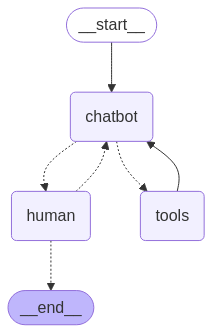

In [13]:
graph_builder = StateGraph(DiaryBotState)

# Add the nodes, including the new tool_node.
graph_builder.add_node("chatbot", chatbot_with_tools)
graph_builder.add_node("human", human_node)
graph_builder.add_node("tools", tool_node)

# Chatbot may go to tools, or human.
graph_builder.add_conditional_edges("chatbot", maybe_route_to_tools)
# Human may go back to chatbot, or exit.
graph_builder.add_conditional_edges("human", maybe_exit_human_node)

# Tools always route back to chat afterwards.
graph_builder.add_edge("tools", "chatbot")

graph_builder.add_edge(START, "chatbot")
graph_with_menu = graph_builder.compile()

Image(graph_with_menu.get_graph().draw_mermaid_png())

In [14]:
config = {"recursion_limit": 100}
state = graph_with_menu.invoke({"messages": []}, config)


Model: Hello! How are you feeling today?


User:  epic


Model: That's fantastic! I'm glad to hear you're feeling epic! 🤩 Here's a little something for you: "Believe you can and you're halfway there." - Theodore Roosevelt.

Would you like me to save your feeling, the emoji, and this quote for today?


User:  ok


Mood logged successfully to 'DiaryBotdb': Mood: epic
Emoji: 🤩
Quote: Believe you can and you're halfway there. - Theodore Roosevelt
Timestamp: 2025-04-19T05:31:52.183959
Model: Great! I've saved your mood, the emoji, and the quote for today. Is there anything else I can help you with?


User:  idk


Model: Okay! If you don't have anything else for me right now, I'll be here when you need me. Remember, even on days when you don't quite know what you need, a little positivity can go a long way. Have a good one!


User:  ok


Model: Have a wonderful day!


User:  you too


Model: Thank you! 😊


User:  bye


Model: Goodbye!


User:  q


In [40]:
state = graph_with_menu.invoke({"messages": []}, config)

Model: Hello! How are you feeling today?


User:  how was i feeling in march?


Model: Okay, let's take a look at how you were feeling in March! Based on your journal entries, I only have one entry for March. On March 1st, you were feeling happy, as indicated by the happy emoji 😀. You also noted that "A good day starts with a smile." It seems you started March off on a positive note! While I don't have many entries for that month, this one suggests a generally cheerful outlook at the beginning of March.


User:  q


In [19]:
### for debugging

#from pprint import pprint
#pprint(state)